# All imports #

In [1]:
from __future__ import print_function

import sys, os
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input

from keras_uncertainty.models import MCDropoutClassifier, MCDropoutRegressor
from keras_uncertainty.utils import numpy_regression_nll
from keras_uncertainty.models import DeepEnsembleRegressor, deep_ensemble_regression_nll_loss



/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/d

In [2]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [3]:
##please select the appropriate folder, willl use os.path.join() for completed script
TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')
x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')
x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)

# Building the model with MC Droput #

In [4]:
'''

Standard deviation based data splitting

We consider the Q features and use the feature with the 

highest SD for dividing the dataset
'''

stats_q_train = pd.DataFrame()
stats_q_train["Mean"] = q_train.mean()
stats_q_train["Var"] = q_train.var()
stats_q_train["STD"] = q_train.std()
stats_q_train["OneSigmaMax"] = stats_q_train["Mean"] + stats_q_train["STD"]
stats_q_train["OneSigmaMin"] = stats_q_train["Mean"] - stats_q_train["STD"]
stats_q_train.T

max_std = stats_q_train["STD"].max()
colomn_max_std = stats_q_train["STD"].idxmax()

maximum = stats_q_train.loc[colomn_max_std, "Mean"] + (1.5 * max_std)
minimum = stats_q_train.loc[colomn_max_std, "Mean"] - (1.5 * max_std)
print(maximum, minimum)

InDistribution_Q_Train = q_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]
OutDistribution_Q_Train = q_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_std].le(minimum)]
InDistribution_X_Train = x_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]
OutDistribution_X_Train = x_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_std].le(minimum)]

InDistribution_Q_Test = q_test[q_test[colomn_max_std].le(maximum) & q_test[colomn_max_std].ge(minimum)]
OutDistribution_Q_Test = q_test[q_test[colomn_max_std].ge(maximum) | q_test[colomn_max_std].le(minimum)]
InDistribution_X_Test = x_test[q_test[colomn_max_std].le(maximum) & q_test[colomn_max_std].ge(minimum)]
OutDistribution_X_Test = x_test[q_test[colomn_max_std].ge(maximum) | q_test[colomn_max_std].le(minimum)]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test

print("//////////////////////")
print(x_train_1.shape, OOD_x_train.shape, x_test_1.shape, OOD_x_test.shape)


0.9119140506494964 -0.5558160506494813
//////////////////////
(13750, 9) (1875, 9) (3840, 9) (256, 9)


In [5]:

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

#In order training set
x_train_1 = x_scaler.fit_transform(x_train_1)
q_train_1 = q_scaler.fit_transform(q_train_1)

#complete test set
x_test = x_scaler.transform(x_test)
q_test = q_scaler.transform(q_test)

#split testing data
IOD_x_test = x_scaler.transform(x_test_1)
IOD_q_test = q_scaler.transform(q_test_1)

OOD_x_test = x_scaler.transform(OOD_x_test)
OOD_q_test = q_scaler.transform(OOD_q_test)

In [6]:

def model_builder():
    input_shape = 9
    output_shape = 18
    depth = 6
    width = 64
    reduction_factor = 1.1
    for i in range(depth):
        num_neurons = max(int(width * (reduction_factor ** i)), 4)
        if i == 0:
            inp = Input(shape=(input_shape,))
            x = Dense(num_neurons, activation='relu')(inp)
        else:
            x = Dense(num_neurons, activation='relu')(x)
            
    mean = Dense(output_shape, activation="sigmoid")(x)
    var = Dense(output_shape, activation="softplus")(x)
    
    train_model = Model(inp, mean)
    pred_model = Model(inp, [mean, var])

    train_model.compile(loss=deep_ensemble_regression_nll_loss(var), optimizer="adam", metrics=["mae"])
    return train_model, pred_model

In [7]:


model = model_builder

print(type(model))

<class 'function'>


In [8]:


with tf.device('/cpu:4'):
    ensemble_model = DeepEnsembleRegressor(model_builder, 3)
    ensemble_model.fit(x_train_1, q_train_1, epochs = 100, batch_size = 128, verbose = 1, validation_data=(IOD_x_test, IOD_q_test))

Instructions for updating:
Colocations handled automatically by placer.
Train on 13750 samples, validate on 3840 samples
Epoch 1/100
13750/13750 [==============================] - 1s 106us/sample - loss: -0.6096 - mean_absolute_error: 0.2621 - val_loss: -0.8990 - val_mean_absolute_error: 0.2347
Epoch 2/100
13750/13750 [==============================] - 1s 62us/sample - loss: -0.9877 - mean_absolute_error: 0.2216 - val_loss: -1.0628 - val_mean_absolute_error: 0.2119
Epoch 3/100
13750/13750 [==============================] - 1s 57us/sample - loss: -1.0990 - mean_absolute_error: 0.2011 - val_loss: -1.1613 - val_mean_absolute_error: 0.2012
Epoch 4/100
13750/13750 [==============================] - 1s 60us/sample - loss: -1.1695 - mean_absolute_error: 0.1947 - val_loss: -1.1609 - val_mean_absolute_error: 0.1964
Epoch 5/100
13750/13750 [==============================] - 1s 62us/sample - loss: -1.2483 - mean_absolute_error: 0.1901 - val_loss: -0.8513 - val_mean_absolute_error: 0.1918
Epoch 6/

Epoch 46/100
13750/13750 [==============================] - 1s 62us/sample - loss: -2.7613 - mean_absolute_error: 0.0484 - val_loss: 44.3339 - val_mean_absolute_error: 0.0570
Epoch 47/100
13750/13750 [==============================] - 1s 60us/sample - loss: -2.8073 - mean_absolute_error: 0.0469 - val_loss: 44.7470 - val_mean_absolute_error: 0.0553
Epoch 48/100
13750/13750 [==============================] - 1s 56us/sample - loss: -2.8219 - mean_absolute_error: 0.0461 - val_loss: 42.5715 - val_mean_absolute_error: 0.0548
Epoch 49/100
13750/13750 [==============================] - 1s 63us/sample - loss: -2.8110 - mean_absolute_error: 0.0461 - val_loss: 45.7883 - val_mean_absolute_error: 0.0555
Epoch 50/100
13750/13750 [==============================] - 1s 63us/sample - loss: -2.8132 - mean_absolute_error: 0.0452 - val_loss: 35.2148 - val_mean_absolute_error: 0.0593
Epoch 51/100
13750/13750 [==============================] - 1s 62us/sample - loss: -2.7963 - mean_absolute_error: 0.0450 - va

Epoch 93/100
13750/13750 [==============================] - 1s 63us/sample - loss: -3.0956 - mean_absolute_error: 0.0333 - val_loss: 47.2357 - val_mean_absolute_error: 0.0440
Epoch 94/100
13750/13750 [==============================] - 1s 62us/sample - loss: -3.1295 - mean_absolute_error: 0.0331 - val_loss: 50.1700 - val_mean_absolute_error: 0.0425
Epoch 95/100
13750/13750 [==============================] - 1s 63us/sample - loss: -3.1410 - mean_absolute_error: 0.0327 - val_loss: 46.2877 - val_mean_absolute_error: 0.0448
Epoch 96/100
13750/13750 [==============================] - 1s 61us/sample - loss: -3.1325 - mean_absolute_error: 0.0327 - val_loss: 51.7907 - val_mean_absolute_error: 0.0427
Epoch 97/100
13750/13750 [==============================] - 1s 61us/sample - loss: -3.1408 - mean_absolute_error: 0.0325 - val_loss: 50.9876 - val_mean_absolute_error: 0.0439
Epoch 98/100
13750/13750 [==============================] - 1s 61us/sample - loss: -3.1474 - mean_absolute_error: 0.0323 - va

13750/13750 [==============================] - 1s 62us/sample - loss: -2.5983 - mean_absolute_error: 0.0492 - val_loss: 9.3242 - val_mean_absolute_error: 0.0602
Epoch 40/100
13750/13750 [==============================] - 1s 62us/sample - loss: -2.6440 - mean_absolute_error: 0.0477 - val_loss: 11.4858 - val_mean_absolute_error: 0.0505
Epoch 41/100
13750/13750 [==============================] - 1s 63us/sample - loss: -2.4233 - mean_absolute_error: 0.0502 - val_loss: 10.9800 - val_mean_absolute_error: 0.0506
Epoch 42/100
13750/13750 [==============================] - 1s 63us/sample - loss: -2.6885 - mean_absolute_error: 0.0454 - val_loss: 4.7398 - val_mean_absolute_error: 0.0515
Epoch 43/100
13750/13750 [==============================] - 1s 63us/sample - loss: -2.5758 - mean_absolute_error: 0.0468 - val_loss: -2.1391 - val_mean_absolute_error: 0.0567
Epoch 44/100
13750/13750 [==============================] - 1s 60us/sample - loss: -2.6090 - mean_absolute_error: 0.0456 - val_loss: 11.1302

Epoch 86/100
13750/13750 [==============================] - 1s 62us/sample - loss: -2.9811 - mean_absolute_error: 0.0325 - val_loss: -1.3006 - val_mean_absolute_error: 0.0528
Epoch 87/100
13750/13750 [==============================] - 1s 62us/sample - loss: -2.9429 - mean_absolute_error: 0.0332 - val_loss: -2.5840 - val_mean_absolute_error: 0.0358
Epoch 88/100
13750/13750 [==============================] - 1s 63us/sample - loss: -2.9799 - mean_absolute_error: 0.0327 - val_loss: -2.4416 - val_mean_absolute_error: 0.0387
Epoch 89/100
13750/13750 [==============================] - 1s 64us/sample - loss: -2.8194 - mean_absolute_error: 0.0340 - val_loss: -2.0415 - val_mean_absolute_error: 0.0400
Epoch 90/100
13750/13750 [==============================] - 1s 60us/sample - loss: -3.0032 - mean_absolute_error: 0.0319 - val_loss: -2.5692 - val_mean_absolute_error: 0.0366
Epoch 91/100
13750/13750 [==============================] - 1s 60us/sample - loss: -2.9468 - mean_absolute_error: 0.0324 - va

13750/13750 [==============================] - 1s 64us/sample - loss: -2.3057 - mean_absolute_error: 0.0819 - val_loss: 13.9815 - val_mean_absolute_error: 0.0831
Epoch 33/100
13750/13750 [==============================] - 1s 62us/sample - loss: -2.3270 - mean_absolute_error: 0.0795 - val_loss: 17.0896 - val_mean_absolute_error: 0.0844
Epoch 34/100
13750/13750 [==============================] - 1s 64us/sample - loss: -2.3443 - mean_absolute_error: 0.0769 - val_loss: 13.0262 - val_mean_absolute_error: 0.0796
Epoch 35/100
13750/13750 [==============================] - 1s 62us/sample - loss: -2.3749 - mean_absolute_error: 0.0751 - val_loss: 13.7902 - val_mean_absolute_error: 0.0767
Epoch 36/100
13750/13750 [==============================] - 1s 61us/sample - loss: -2.4371 - mean_absolute_error: 0.0714 - val_loss: 22.9085 - val_mean_absolute_error: 0.0750
Epoch 37/100
13750/13750 [==============================] - 1s 62us/sample - loss: -2.4685 - mean_absolute_error: 0.0694 - val_loss: 23.73

Epoch 79/100
13750/13750 [==============================] - 1s 61us/sample - loss: -2.7571 - mean_absolute_error: 0.0372 - val_loss: 33.8479 - val_mean_absolute_error: 0.0417
Epoch 80/100
13750/13750 [==============================] - 1s 63us/sample - loss: -3.0794 - mean_absolute_error: 0.0327 - val_loss: 44.2290 - val_mean_absolute_error: 0.0400
Epoch 81/100
13750/13750 [==============================] - 1s 63us/sample - loss: -3.0829 - mean_absolute_error: 0.0329 - val_loss: 41.5975 - val_mean_absolute_error: 0.0393
Epoch 82/100
13750/13750 [==============================] - 1s 64us/sample - loss: -3.0872 - mean_absolute_error: 0.0321 - val_loss: 38.6190 - val_mean_absolute_error: 0.0403
Epoch 83/100
13750/13750 [==============================] - 1s 60us/sample - loss: -3.1093 - mean_absolute_error: 0.0318 - val_loss: 42.2804 - val_mean_absolute_error: 0.0405
Epoch 84/100
13750/13750 [==============================] - 1s 64us/sample - loss: -3.0920 - mean_absolute_error: 0.0322 - va

In [10]:
mean_test_IOD, sd_test_IOD = ensemble_model.predict(IOD_x_test)
mean_test_IOD = q_scaler.inverse_transform(mean_test_IOD)
sd_test_IOD = q_scaler.inverse_transform(sd_test_IOD)
q_test_unorm = q_scaler.inverse_transform(IOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_IOD, sd_test_IOD**2)))

NLL: -1.39251


In [12]:
mean_test_OOD, sd_test_OOD = ensemble_model.predict(OOD_x_test)
mean_test_OOD = q_scaler.inverse_transform(mean_test_OOD)
sd_test_OOD = q_scaler.inverse_transform(sd_test_OOD)
q_test_unorm = q_scaler.inverse_transform(OOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_OOD, sd_test_OOD**2)))

NLL: -1.75215


-0.5097072
-0.6725072


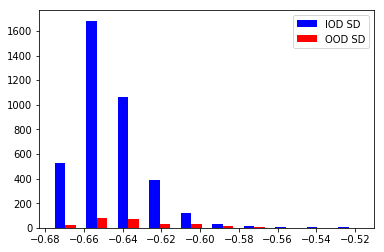

In [14]:
sd_test_IOD_df = pd.DataFrame(sd_test_IOD)
sd_test_OOD_df = pd.DataFrame(sd_test_OOD)
new_scores = np.concatenate([sd_test_IOD_df[0], sd_test_OOD_df[0]], axis=0)
new_labels = np.concatenate([np.zeros_like(sd_test_IOD_df[0]), np.ones_like(sd_test_OOD_df[0])], axis=0)
histogram_df = pd.DataFrame(new_scores, new_labels)
print(new_scores.max())
print(new_scores.min())
#histogram_df.hist(column=0)

#sd_test_IOD_df.hist(column=0)
#sd_test_OOD_df.hist(column=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(sd_test_IOD_df[0])
b_heights, b_bins = np.histogram(sd_test_OOD_df[0], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width = width, facecolor='blue',label="IOD SD")
ax.bar(b_bins[:-1]+width, b_heights, width = width, facecolor='red', label="OOD SD")
ax.legend()


0.6361063639322917


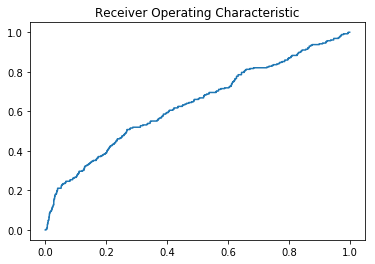

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score

norm_scores = new_scores - min(new_scores) / (max(new_scores) - min(new_scores))

auc = roc_auc_score(new_labels, new_scores)
fpr, tpr, threshs = roc_curve(new_labels, norm_scores, drop_intermediate=True)
print(auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.show()
